## One-vs-all logistic regression and neural networks to recognize hand-written digits

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm #Used to display images in a specific colormap

# load MATLAB files
from scipy.io import loadmat
from scipy.optimize import minimize
import scipy.misc #Used to show matrix as an image

from sklearn.linear_model import LogisticRegression

#pd.set_option('display.notebook_repr_html', False)
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', 150)
#pd.set_option('display.max_seq_items', None)
 

## Multi-class Classification
There are 5000 training examples in ex3data1.mat, where each training
example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is
represented by a floating point number indicating the grayscale intensity at
that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional
vector. Each of these training examples becomes a single row in our data
matrix X. This gives us a 5000 by 400 matrix X where every row is a training
example for a handwritten digit image.

The second part of the training set is a 5000-dimensional vector y that
contains labels for the training set.

In [2]:
data = loadmat('3. Multi-class Classification and Neural Networks/ex3/ex3data1.mat')
data.keys()
#print(data)

weights = loadmat('3. Multi-class Classification and Neural Networks/ex3/ex3weights.mat')
weights.keys()

y = data['y']
y[y == 10] = 0
print('y',y)
x = data['X']

print('data',data.keys())
print('weights',weights.keys(),'\n')
print('y.shape',y.shape,'x.shape',x.shape)

# Add constant for intercept
X = np.c_[np.ones((data['X'].shape[0],1)), data['X']]
print('X: {} (with intercept)'.format(X.shape))

theta1, theta2 = weights['Theta1'], weights['Theta2']
print('theta1: {}'.format(theta1.shape))
print('theta2: {}'.format(theta2.shape))

y [[0]
 [0]
 [0]
 ...
 [9]
 [9]
 [9]]
data dict_keys(['y', '__version__', 'X', '__globals__', '__header__'])
weights dict_keys(['Theta2', '__version__', 'Theta1', '__globals__', '__header__']) 

y.shape (5000, 1) x.shape (5000, 400)
X: (5000, 401) (with intercept)
theta1: (25, 401)
theta2: (10, 26)


[4020  524 4844 1959 3565 4129 2925 4260 2426  201 3945 2696 4399 4402
 4798 2483 3434 1868 1968 3239]


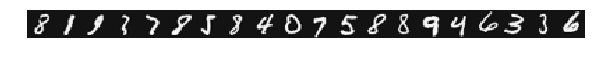

In [3]:
fig = plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
sample = np.random.choice(X.shape[0], 20)
print(sample)
plt.imshow(X[sample,1:].reshape(-1,20).T,cmap = cm.Greys_r)
plt.axis('off');

/home/johan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:46: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


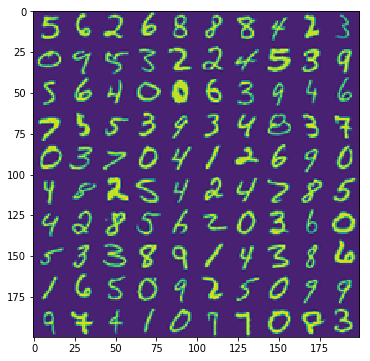

In [4]:
import random #To pick random images to display

def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    #Deleting the constant for intercept
    f = row[1:]
    #print('f',f)
    #Convert the features'vector to a matrix 20*20 acording to each index
    square = f.reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        #Take 100 examples in a radom way
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        #print('indices_to_display',indices_to_display)
    # Define the size of the big image that might containg the 100 random digits
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
            
        #print('X[idx]',X[idx])
        iimg = getDatumImg(X[idx])
        #print ('iimg',iimg)
        #
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        #Incrementing row in 1. It allows to change print in different rows.
        icol += 1
        #print('icol',icol,'irow',irow)
    fig = plt.figure(figsize=(6,6))
    #Takes a numpy array and returns a PIL image.
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img)

displayData()

Logistic regression hypothesis

$$ h_{\theta}(x) = g(\theta^{T}x)$$
$$ g(z)=\frac{1}{1+e^{−z}} $$

In [5]:
def sigmoid(z):
    return(1 / (1 + np.exp(-z)))

Regularized Cost Function 
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}\, log\,( h_\theta\,(x^{(i)}))-(1-y^{(i)})\,log\,(1-h_\theta(x^{(i)}))\big] + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$
Vectorized Cost Function
$$ J(\theta) = \frac{1}{m}\big((\,log\,(g(X\theta))^Ty+(\,log\,(1-g(X\theta))^T(1-y)\big) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}$$


In [6]:
def lrcostFunctionReg(theta, reg, X, y):
    m = y.size
    h = sigmoid(X.dot(theta))
    
    J1 = (1/m)*(np.log(h).T.dot(y)+np.log(1-h).T.dot(1-y))
    J = -1*J1 + (reg/(2*m))*np.sum(np.square(theta[1:]))
    
    if np.isnan(J[0]):
        return(np.inf)
    return(J[0])    

$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m} ( h_\theta (x^{(i)})-y^{(i)})x^{(i)}_{j} + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2} $$ 


Vectorized


$$ \frac{\delta J(\theta)}{\delta\theta_{j}} = \frac{1}{m} X^T(h_\theta(x)-y)+\frac{ \lambda}{m}\theta$$

In [7]:
def lrgradientReg(theta, reg, X,y):
    m = y.size
    h = sigmoid(X.dot(theta.reshape(-1,1)))
    # This is used to concatenate any number of array slices along row (first) axis, row
    thetha_or = np.r_[[[0]],theta[1:].reshape(-1,1)]
    #print('theta[1:]',theta[1:],'theta[1:].reshape',theta[1:].reshape(-1,1))
    grad = (1/m)*X.T.dot(h-y) + (reg/m)* thetha_or
        
    return(grad.flatten())

I will implement one-vs-all classification by
training multiple regularized logistic regression classifiers, one for each of
the K classes in our dataset. In the handwritten digits dataset,
K = 10. The code should return all the classifier parameters
in a matrix Θ ∈ R K×(N +1) , where each row of Θ corresponds to the learned
logistic regression parameters for one class. You can do this with a “for”-loop
from 1 to K, training each classifier independently.

In [8]:
def oneVsAll(features, classes, n_labels, reg):
    initial_theta = np.zeros((X.shape[1],1))  # 401x1
    all_theta = np.zeros((n_labels, X.shape[1])) #10x401

    for c in np.arange(0, n_labels):
        print ('Finished oneVsAll checking number: %d' %c)
        res = minimize(lrcostFunctionReg, initial_theta, args=(reg, features, (classes == c)*1), method=None,
                       jac=lrgradientReg, options={'maxiter':100})
        all_theta[c] = res.x
    print ('All the numbers have been checked')
    return(all_theta)

In [9]:
theta = oneVsAll(X, y, 10, 0.01)

Finished oneVsAll checking number: 0
Finished oneVsAll checking number: 1
Finished oneVsAll checking number: 2
Finished oneVsAll checking number: 3
Finished oneVsAll checking number: 4
Finished oneVsAll checking number: 5
Finished oneVsAll checking number: 6
Finished oneVsAll checking number: 7
Finished oneVsAll checking number: 8
Finished oneVsAll checking number: 9
All the numbers have been checked


In [10]:
def predictOneVsAll(all_theta, features):
    probs = sigmoid(X.dot(all_theta.T))
    # Adding one because Python uses zero based indexing for the 10 columns (0-9),
    # while the 10 classes are numbered from 1 to 10.
    return(np.argmax(probs, axis=1))

pred = predictOneVsAll(theta, X)
print('pred',pred,'Examples:',len(pred))
print('y',y.ravel(), 'Examples:',len(y.ravel()))
#The arithmetic mean is the sum of the elements along the axis divided by
#the number of elements.
print('Training set accuracy: {} %'.format(np.mean(pred == y.ravel())*100))

pred [0 0 0 ... 9 9 7] Examples: 5000
y [0 0 0 ... 9 9 9] Examples: 5000
Training set accuracy: 94.98 %


Using sklearn.linear_model

In [11]:
clf = LogisticRegression(C=10, penalty='l2', solver='liblinear')
# Scikit-learn fits intercept automatically, so we exclude first column with 'ones' from X when fitting.
clf.fit(X[:,1:],y.ravel())

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
pred2 = clf.predict(X[:,1:])
print('Training set accuracy: {} %'.format(np.mean(pred2 == y.ravel())*100))

Training set accuracy: 96.5 %


## Neural Networks


In this part of the exercise, we will implement a neural network to recognize handwritten digits using the same training set as before. We will be using parameters from a already trained neural network for this exercise.


In [13]:
input_layer_size = 400  # 20x20 Input Images of Digits
hidden_layer_size = 25  # 25 hidden units
num_labels = 10         # 10 labels, from 1 to 10 (note that we have mapped "0" to label 10)

In [14]:
mat_data = loadmat('3. Multi-class Classification and Neural Networks/ex3/ex3data1.mat')
mat_param = loadmat('3. Multi-class Classification and Neural Networks/ex3/ex3weights.mat')

Theta_1 = mat_param['Theta1']
Theta_2 = mat_param['Theta2']
X = mat_data['X']
y = mat_data['y'].ravel()
m, n = X.shape
print('m,n',m,n)

m,n 5000 400


The predict() function predicts the label of an input given a trained neural network.

In [15]:
def predict(Theta_1, Theta_2, X):
    #X : ndarray, shape (n_samples, n_features)
    #Samples, where n_samples is the number of samples and n_features is the number
    # of features.

    m, n = X.shape
    X = np.hstack((np.ones((m, 1)), X))
    A_1 = sigmoid(X.dot(Theta_1.T))
    A_1 = np.hstack((np.ones((m, 1)), A_1))
    A_2 = sigmoid(A_1.dot(Theta_2.T))

    p = np.argmax(A_2, axis=1)
    p += 1  # The theta_1 and theta_2 are loaded from Matlab data, 
    #in which the matrix index starts from 1.

    return p

In [16]:
#Calculate the accuracy on training set:
pred = predict(Theta_1, Theta_2, X)
print ('Training Set Accuracy:', np.mean(pred == y) * 100)

Training Set Accuracy: 97.52


In [17]:
def getDatumImg_2(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    f = row
    width, height = 20, 20
    #Deleting the constant for intercept
    #print('f',f)
    #Convert the features'vector to a matrix 20*20 acording to each index
    square = f.reshape(width,height)
    return square.T

To sum up, I randomly select 5 samples to predict one at a time and to see what it is predicting.

Displaying Example Image
400
Neural Network Prediction: [10] (digit [0])


/home/johan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  


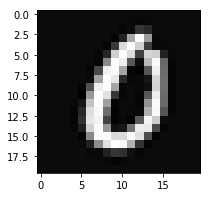

Displaying Example Image
400
Neural Network Prediction: [4] (digit [4])


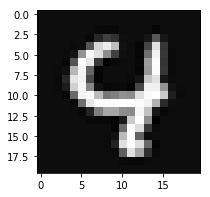

Displaying Example Image
400
Neural Network Prediction: [8] (digit [8])


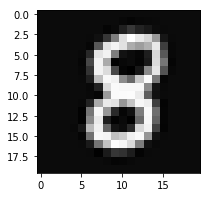

Displaying Example Image
400
Neural Network Prediction: [7] (digit [7])


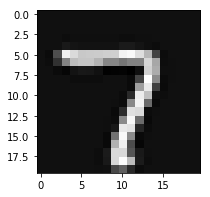

Displaying Example Image
400
Neural Network Prediction: [8] (digit [8])


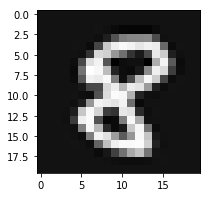

In [18]:
rp = np.random.permutation(m)
for i in range(5):
    print ('Displaying Example Image')
    fig = plt.figure(figsize=(3,3))
    print(len(X[i]))
    img = scipy.misc.toimage(getDatumImg_2(X[rp[i]]) )
    plt.imshow(img,cmap = cm.Greys_r)
    pred = predict(Theta_1, Theta_2, X[rp[i],].reshape(1, n))
    print ('Neural Network Prediction: {} (digit {})'.format(pred, pred % 10))
    plt.show()